In [96]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from numpy.linalg import svd
from numpy.linalg import norm

# Project a matrix by replacing missing entries/NaNs with zeros

In [97]:
def project(X):
    """Replace the missing entries of a
    matrix X by zeros.
    """
    return np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    

# The SVT Algorithm

For details see the paper [https://arxiv.org/pdf/0810.3286.pdf] (sections 5.1.5 and 5.2.1 especially)

In [98]:
def svt(M, tau: float = None, delta: float = None, epsilon: float = 1e-3,
        k_max: int = 200, soft_thresholding: bool = False, debug: bool = False):
    """SVT (singular value thresholding) algorithm
    """
    
    assert len(M.shape) == 2, 'svt: Input matrix must be 2 dimensional'
    m = (~np.isnan(M)).sum()
    assert m > 0, 'all entries of input matrix are nans'
    n1, n2 = M.shape
    norm_M = norm(project(M), 'fro')
    assert norm_M > 0, 'Frobenius norm of the projection of the input matrix is zero.'

    import pdb
    if debug:
        pdb.set_trace()

    if tau is None:
        #tau = 5 * n1
        tau = 5 * norm_M

    if delta is None:
        delta = 1.2 * n1 * n2 / m

    k_0 = np.ceil(tau / (delta * norm_M))
    Y = k_0 * delta * project(M)
    iteration_error = {}
    iteration_rank = {}

    for k in range(k_max):
        U, S, Vh = svd(Y, full_matrices=False)
        S_threshold = np.maximum(S - tau, 0)
        sigma_max = S_threshold.max()
        S_threshold = S_threshold[S_threshold > sigma_max * 1e-10]
        r_k = len(S_threshold)

        if soft_thresholding:
            s = S[:r_k]
        else:
            s = S_threshold
        X = (U[:, :r_k] * s) @ Vh[:r_k, :]

        iteration_rank[k] = r_k
        iteration_error[k] = norm(project(M - X), 'fro') / norm_M
        if iteration_error[k] <= epsilon:
            break

        Y = project(Y + delta * (M - X))
    return X, s, U, S, Vh, iteration_rank, iteration_error



In [ ]:
def svt_new(M, tau: float = None, delta: float = None, epsilon: float = 1e-3,
        k_max: int = 200, soft_thresholding: bool = False, debug: bool = False):
    """SVT (singular value thresholding) algorithm
    """
    
    assert len(M.shape) == 2, 'svt: Input matrix must be 2 dimensional'
    m = (~np.isnan(M)).sum()
    assert m > 0, 'all entries of input matrix are nans'
    n1, n2 = M.shape
    norm_M = norm(project(M), 'fro')
    assert norm_M > 0, 'Frobenius norm of the projection of the input matrix is zero.'

    import pdb
    if debug:
        pdb.set_trace()

    if tau is None:
        #tau = 5 * n1
        tau = 5 * norm_M

    if delta is None:
        delta = 1.2 * n1 * n2 / m

    k_0 = np.ceil(tau / (delta * norm_M))
    Y = k_0 * delta * project(M)
    iteration_error = {}
    iteration_rank = {}

    for k in range(k_max):
        U, S, Vh = svd(Y, full_matrices=False)
        S_threshold = np.maximum(S - tau, 0)
        sigma_max = S_threshold.max()
        S_threshold = S_threshold[S_threshold > sigma_max * 1e-10]
        r_k = len(S_threshold)

        if soft_thresholding:
            s = S[:r_k]
        else:
            s = S_threshold
        X = (U[:, :r_k] * s) @ Vh[:r_k, :]

        iteration_rank[k] = r_k
        iteration_error[k] = norm(project(M - X), 'fro') / norm_M
        if iteration_error[k] <= epsilon:
            break

        Y = project(Y + delta * (M - X))
    return X, s, U, S, Vh, iteration_rank, iteration_error



# Generate Low Rank Data

In [99]:
t = np.linspace(0, 1, 200)
w = np.linspace(0, 2*np.pi, 5)
A = np.zeros((len(t), len(w)))
for k, wk in enumerate(w):
    A[:, k] = np.sin(wk * t)

A = np.column_stack([A, A, A, A])
B = A.copy()

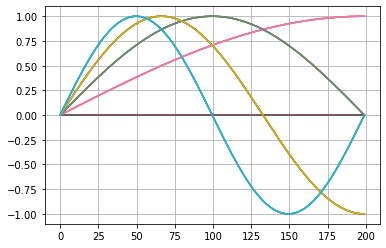

In [107]:
plt.plot(A)
plt.grid(True)

# Introdcue missing data randomly

In [100]:
mask = np.random.rand(A.shape[0], A.shape[1]) < .3

In [101]:
B[mask] = np.nan

In [102]:
np.isnan(B).sum() / np.prod(B.shape)

0.299

# The rank of the original data

In [103]:
U, S, Vh = svd(A, full_matrices=False)
np.linalg.matrix_rank(A, tol=1e-5)

4

# Apply the SVT algorithm

In [113]:
X, T, U, S, Vh, iteration_rank, iteration_error = svt(B, epsilon=5e-3, debug=False)

# Observe the results

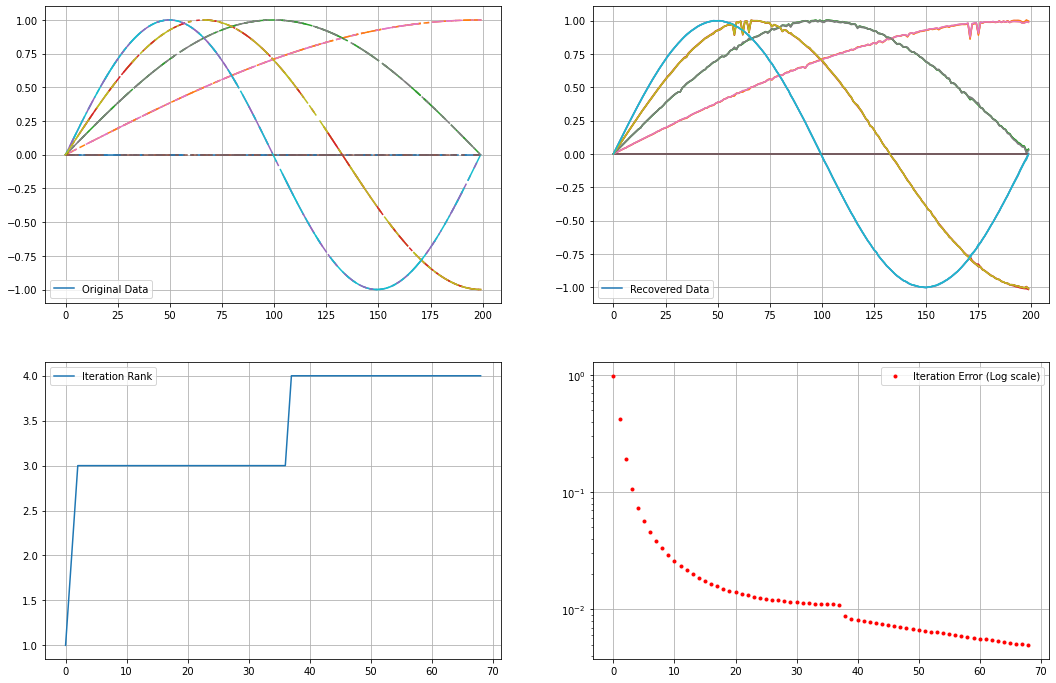

In [120]:
plt.figure(figsize=(18, 6 * 2))
g_m, g_n = (2, 2)


plt.subplot(g_m, g_n, 1)
plt.plot(B)
plt.legend(['Original Data'])
plt.grid(True)

plt.subplot(g_m, g_n, 2)
plt.plot(X)
plt.legend(['Recovered Data'])
plt.grid(True)

plt.subplot(g_m, g_n, 3)
plt.plot(iteration_rank.values())
plt.legend(['Iteration Rank'])
plt.grid(True)

plt.subplot(g_m, g_n, 4)
plt.semilogy(iteration_error.values(), 'r.')
plt.legend(['Iteration Error (Log scale)'])
plt.grid(True)
